In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from multiprocess import Pool
import multiprocess

In [3]:
%matplotlib inline

# Molecular dynamics

In this assignment, a system of particles in fcc lattice of 4 $\times$ 4 $\times$ 4 unit cells is considered leading to a total number of particles of 256. The Lennard-Jones potential is used in this case which is,
$$V_{LJ} = 4\epsilon [\Big(\frac{\sigma}{r}\Big)^{12} - \Big(\frac{\sigma}{r}\Big)^{6}]$$
A reduced system of units is considered here where $V^*$ = $V/\epsilon$ and $r^*$ = $r/\sigma$. All the quantities later will be mentioned in these units.

Using an initial Temperature of 0.2 and density of 0.55, Molecular dynamics simulation is carried on to study the evolution. In order to simulate large systems in this small 4 $\times$ 4 $\times$ 4 system, we need to apply periodic boundary conditions. We have to consider all the particles in the 26 adjacent cells of the simulation cell for computing force within an $r_c$ cut off. The final Energies and forces are calculated only for the particles in the simulation cell considering interactions from particles of all the adjacent cells.

In [4]:
# Given initial conditions
rho = 0.55
a = (4/rho)**(1/3)
n = 4
V = (n**3)*(a**3)
N = 4*(n**3)
Ti = 0.2

# Creating fcc lattice
a1 = a*np.array([0.5,0.5,0])
a2 = a*np.array([1,0,0])
a3 = a*np.array([0.5,0,0.5])
a4 = a*np.array([0,0,1])
#r1 = [np.array([0,0,0]),np.array([0.5,0.5,0]),np.array([1,0,0]),np.array([0,1,0])np.array([1,1,0])]
r1=[]
for i in range(8):
    for j in range(4):
        r1.append(np.array([(i*a1[0]+j*a2[0])%(a*n),(i*a1[1]+j*a2[1])%(a*n),(i*a1[2]+j*a2[2])%(a*n)]))
r1 = np.array(r1)
r2 = []
for i in range(32):
    r2.append(np.array([(r1[i][0]+a3[0])%(a*n),(r1[i][1]+a3[1])%(a*n),(r1[i][2]+a3[2])%(a*n)]))
r2 = np.array(r2)
r3 = []
rl = r1
rp = r2
for i in range(3):
    rp1 = []
    rp2 = []
    
    for j in range(32):
        rp1.append(np.array([(rl[j][0]+a4[0])%(a*n),(rl[j][1]+a4[1])%(a*n),(rl[j][2]+a4[2])%(a*n)]))
        rp2.append(np.array([(rp[j][0]+a4[0])%(a*n),(rp[j][1]+a4[1])%(a*n),(rp[j][2]+a4[2])%(a*n)]))
    rp1 = np.array(rp1)
    rp2 = np.array(rp2)
    r3.append(np.concatenate((rp1,rp2)))
    rl = rp1
    rp = rp2
r3 = np.array(r3)
r = np.concatenate((r1,r2,r3[0],r3[1],r3[2]))
#r = a * r  
        

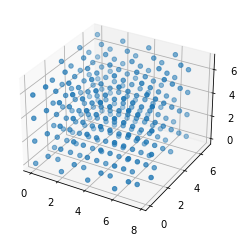

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[:,0],r[:,1],r[:,2])

In [6]:
# Generating velocity
v = []
for i in range(N):
    vp = []
    for j in range(3):
        temp = np.random.normal(0,np.sqrt(Ti))
        vp.append(temp)
    v.append(np.array(vp))
v = np.array(v)

In [11]:
steps = 3000
de = 0.005

rf = np.zeros((steps,N,3))
rf[0] = r
# rf stores the configuration of N particle at each time step

vf = np.zeros((steps,N,3))
vf[0] = v
# vf stores the velocity of each particle at each time step

rc = 2.5 # cut off

In [12]:
# For periodic boundary condition, the corresponding points on all the adjacent boxes are considered.
# Image lattices
# R_im takes a point from one sample cell to an adjacent one.

R_im = np.zeros((27,3))
vec = np.array([0,0,0])
R_im[0] = vec + np.array([1,1,1])*n*a
R_im[1] = vec + np.array([1,1,0])*n*a
R_im[2] = vec + np.array([1,1,-1])*n*a

R_im[3] = vec + np.array([1,0,1])*n*a
R_im[4] = vec + np.array([1,0,0])*n*a
R_im[5] = vec + np.array([1,0,-1])*n*a

R_im[6] = vec + np.array([1,-1,1])*n*a
R_im[7] = vec + np.array([1,-1,0])*n*a
R_im[8] = vec + np.array([1,-1,-1])*n*a

R_im[9] = vec + np.array([0,1,1])*n*a
R_im[10] = vec + np.array([0,1,0])*n*a
R_im[11] = vec + np.array([0,1,-1])*n*a

R_im[12] = vec + np.array([0,0,1])*n*a
R_im[13] = vec + np.array([0,0,0])*n*a
R_im[14] = vec + np.array([0,0,-1])*n*a

R_im[15] = vec + np.array([0,-1,1])*n*a
R_im[16] = vec + np.array([0,-1,0])*n*a
R_im[17] = vec + np.array([0,-1,-1])*n*a

R_im[18] = vec + np.array([-1,1,1])*n*a
R_im[19] = vec + np.array([-1,1,0])*n*a
R_im[20] = vec + np.array([-1,1,-1])*n*a

R_im[21] = vec + np.array([-1,0,1])*n*a
R_im[22] = vec + np.array([-1,0,0])*n*a
R_im[23] = vec + np.array([-1,0,-1])*n*a

R_im[24] = vec + np.array([-1,-1,1])*n*a
R_im[25] = vec + np.array([-1,-1,0])*n*a
R_im[26] = vec + np.array([-1,-1,-1])*n*a

In [13]:
# Defining functions for energy and force.
def KE(v):
    # v - velocity of all particles
    return np.sum((1/2)*np.sum(v**2,axis=1))/N

def PE_force(td,i_d):
    # ti = time index
    # i_d = particle index
    
    U_id = 0 # PE for particle index i_d
    force = np.zeros(3)
    
    d_arr = (rf[td] - rf[td][i_d])
    for j in range(N):
        R = R_im + d_arr[j]
        d2 = np.sum(R**2,axis = 1)
        m = np.argmin(d2)
        d = np.sqrt(np.min(d2))
        if (0 < d < rc):
            U_id = U_id + 4*((1/d)**12-(1/d)**6)
            force = force + (-(24/d**2)*(2*(1/d)**12 - (1/d)**6))*R[m]
    return [U_id,force]

In [14]:
# Initial values of energies, temperature and pressure
U = np.zeros(steps-1)
for i in range(N):
    U[0] = U[0] + PE_force(0,i)[0]
U[0] = U[0]/(2*N)
K = np.zeros(steps-1)
K[0] = KE(vf[0])

T = np.zeros(steps-1)
T[0] = (2/3)*K[0]

P = np.zeros(steps-1)
P[0] = (N/V)*T[0]

E = np.zeros(steps-1)
E[0] = K[0] + U[0]

In [15]:
# First iterate using verlet algorithm
for i in range(N):
    f = PE_force(0,i)[1]
    rm = rf[0][i] - vf[0][i]*de + (1/2)*f*de*de
    rf[1][i] = 2*rf[0][i] - np.array(rm) + f*de*de

rf = rf%(n*a)

In [17]:
def md_evolve(ind):
    # ti_: atom index
    # ii: time index
    
    ti_,ii = ind
    
    A = PE_force(ii,ti_)
    U_ = A[0]/(2*N)
    f_ = A[1]
    
    
    del_ = rf[ii][ti_]-rf[ii-1][ti_] 
    '''difference of position of a particle in adjacent time steps.
     This should not be > rc. Incase it is (happens only if a particle crosses boundary and is taken back in by 
     modulo function), it is subtracted by n*a. This will give the actual displacement happened in 
     that time step which is required in the verlet algorithm.'''
    
    for j in range(3):
        if(del_[j]**2>rc**2):
            
            del_[j] = np.sign(del_[j])*(np.abs(del_[j])-n*a)
            
    
    verlet_it = rf[ii][ti_] + del_ + f_*(de**2)
    vel = (del_ + (1/2)*f_*(de**2))/de
    
    return [verlet_it,U_,vel]

In [19]:
# Only for mac os
import os
os.system("taskset -p 0xfffff %d" % os.getpid())

32512

In [18]:
# This runs the code 4000 times to build the functions of Energy and Temperature.

# Multiprocessing is used to run this as it takes a lot of time.
st = []
for i in range(N):
    st.append((i,1))
    
# st is the array of tuples which is given as input to md_evolve in pool.map function. This is how pool.map takes values

for ti in range(1,steps-1):
    
    
    pool = Pool(processes=7)
    res = pool.map(md_evolve,st,chunksize=int(N/6.5))
    pool.close()
   
    
    for i in range(N):
        rf[ti+1][i] = res[i][0]
        vf[ti][i] = res[i][-1]
        st[i] = (i,ti+1)
    
    # We get the configurations at different time steps
    rf = rf%(n*a)
    
    U[ti] = np.sum(np.array(res)[:,1],dtype=object) 
    K[ti] = KE(vf[ti])
    T[ti] = (2/3)*K[ti]

# The note below is just a warning. The code runs fine.
# Please install 'multiprocess' (if not already there) to run this.

<ipython-input-18-40f13ad3d2c5>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  U[ti] = np.sum(np.array(res)[:,1],dtype=object)


From the above code, I have generated an array of positions which holds the data of positions of all the particles in every time step. Along with the positions, I have generated an array of the potential, kinetic, total energy and temperature in every time step. Below are the plots of these quantities.

Text(0.5, 1.0, 'Plot of Energies and Temperature with time')

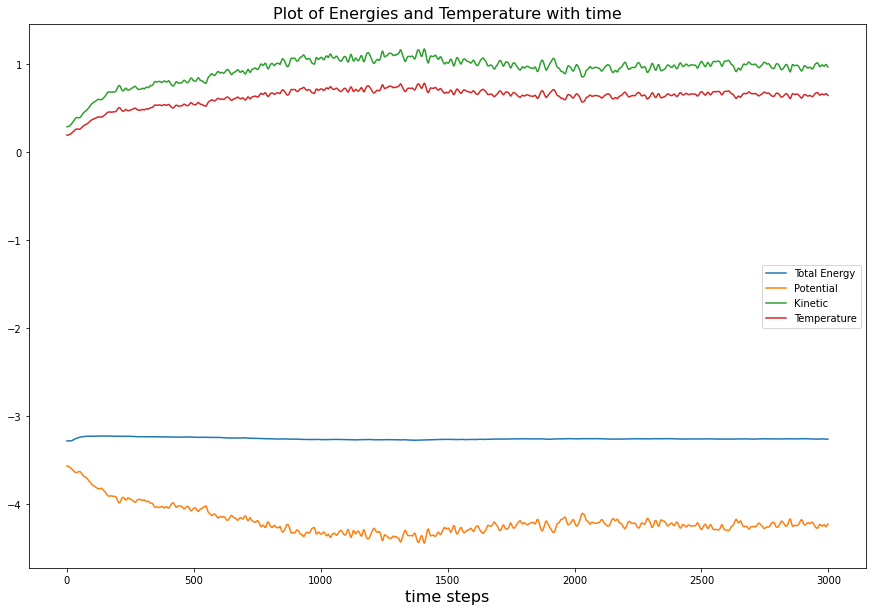

In [34]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ts = np.linspace(1,steps-2,steps-1)
ax.plot(ts,U+K)
ax.plot(ts,U)
ax.plot(ts,K)
ax.plot(ts,T)
plt.legend(['Total Energy','Potential','Kinetic','Temperature'])
plt.xlabel('time steps',fontsize = 16)
plt.title('Plot of Energies and Temperature with time',fontsize = 16)

There is thermalisation after arround 2000 steps. Below are the plots of the functions after thermalisation.

Text(0.5, 1.0, 'Plot of Total energy and Potential with time after thermalisation')

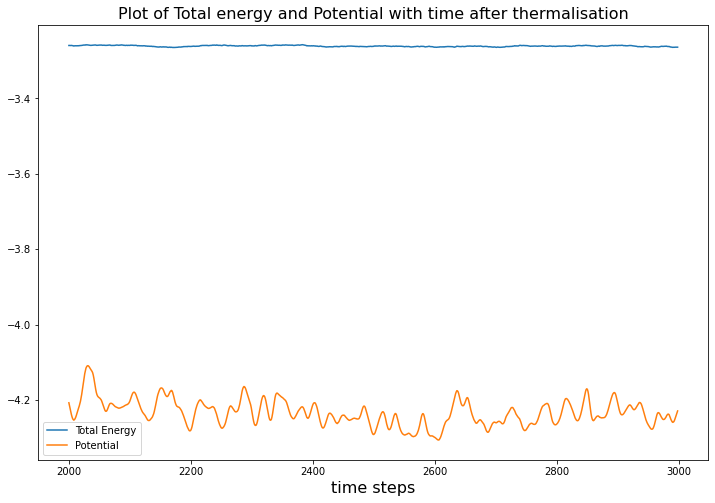

In [35]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ts = np.linspace(1,steps-2,steps-1)
ax.plot(ts[2000:],U[2000:]+K[2000:])
ax.plot(ts[2000:],U[2000:])
#ax.plot(ts,K)
#ax.plot(ts,T)
plt.legend(['Total Energy','Potential'])
plt.xlabel('time steps',fontsize = 16)
plt.title('Plot of Total energy and Potential with time after thermalisation',fontsize = 16)

Text(0.5, 1.0, 'Plot of Kinetic energy and Temperature with time after thermalisation')

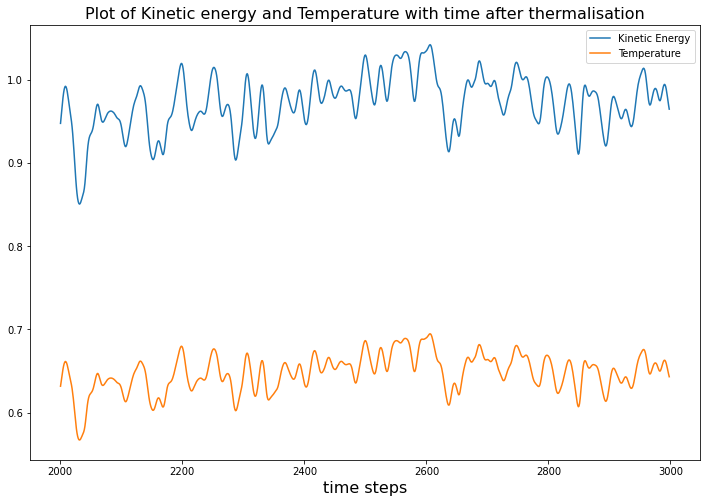

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ts = np.linspace(1,steps-2,steps-1)
#ax.plot(ts[2000:],U[2000:]+K[2000:])
#ax.plot(ts[2000:],U[2000:])
ax.plot(ts[2000:],K[2000:])
ax.plot(ts[2000:],T[2000:])
plt.legend(['Kinetic Energy','Temperature'])
plt.xlabel('time steps',fontsize = 16)
plt.title('Plot of Kinetic energy and Temperature with time after thermalisation',fontsize = 16)